In [ ]:
## Imports
import os
import sys
import time
from collections import defaultdict

import numpy as np 
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

In [2]:
## Set-up

# Add scripts folder to PATH
repo_root = os.path.abspath("..")  # one level up from /notebook
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)
# import loading script
from scripts.MNIST import load_mnist

# setting device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Load and set-up data

In [7]:
# Define the transformation to convert to Tensor and flatten it
flatten_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.flatten()) # Flattens the C x H x W tensor to a 1D vector
])

DATA_DIR = "../data"

# Download and load the training dataset with the new transformation
train_dataset = datasets.MNIST(
    root = DATA_DIR,
    train = True,
    transform = flatten_transform,
    download = True
)

# Download and load the test dataset with the new transformation
test_dataset = datasets.MNIST(
    root = DATA_DIR,
    train = False,
    transform = flatten_transform,
    download = True
)

100%|██████████| 9.91M/9.91M [00:04<00:00, 2.26MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 144kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.09MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.77MB/s]


In [8]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
# Get the first image and its label from the training dataset
first_image, first_label = train_dataset[0]

# Print the shape of the image tensor
print(f"Shape of the first image: {first_image.shape}")
print(f"Label of the first image: {first_label}")

Number of training samples: 60000
Number of test samples: 10000
Shape of the first image: torch.Size([784])
Label of the first image: 5


In [12]:
## Set hyperparameters
BATCH_SIZE = 128

## Making data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset_size = test_dataset.data.shape[0]
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_dataset_size, shuffle=True)

## 2. Set-up MoE model

In [13]:
class OneLayerExpert(torch.nn.Module):
    """Simple expert with only one hidden layer"""
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # Hidden layer
        self.l_1 = torch.nn.Linear(input_size, hidden_size)
        self.relu_1 = torch.nn.ReLU()
        
        self.output = torch.nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.relu_1(self.l_1(x))
        x = self.output(x)
        return x

class Gating(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.l_1 = torch.nn.Linear(input_size, hidden_size)
        self.relu_1 = torch.nn.ReLU()
        self.output = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu_1(self.l_1(x))
        x = self.output(x)
        # Apply softmax through expert/output dimension, so we get probability distribution
        x = F.softmax(x, dim=-1) 
        return x

class SoftMOE(torch.nn.Module):
    def __init__(self, input_size, hidden_size_experts, hidden_size_gating, num_experts, output_size):
        super().__init__()
        # Creating gating layer
        self.gate = Gating(
            input_size = input_size, 
            hidden_size = hidden_size_gating, 
            output_size = num_experts
        )
        # Create experts
        self.experts = nn.ModuleList(
            [OneLayerExpert(
                input_size=input_size, 
                hidden_size = hidden_size_experts, 
                output_size = output_size
            ) for _ in range(num_experts)]
        )

    def forward(self, x):
        # if B = batch_size, N = expert_num, D_out = expert output dimension
        gating_output = self.gate(x) # shape: (B, N)
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=2) # shape: (B, D_out, N)
        
        # Calculating weighted sum:
        # 1. gating_output.unsqueeze -> (B, N, 1)
        # 2. torch.bmm(...) -> (B, D_out, 1)
        # 3. .squeeze(2) -> (B, D_out)
        output = torch.bmm(expert_outputs, gating_output.unsqueeze(2)).squeeze(2)
        return output # shape: (B, D_out)

## 3. Training phase

### 3.1 Set-up

In [17]:
def calculate_accuracy(outputs, labels):
    _, output_index = torch.max(outputs, 1)
    return (output_index == labels).sum().item() / labels.size(0)

def training_loop(train_loader, test_loader, num_epochs, model, loss_function, optimizer):
    # Metrics
    training_loss = []
    training_accuracy = []
    test_loss = []
    test_accuracy =[]
    
    print("Starting the Training Loop")
    for epoch in range(num_epochs):
        model.train()
        batch_loss = []
        batch_accuracy = []
        
        # Loop through batches (Training Phase)
        for batch_index, (data, label) in enumerate(train_loader):
            data = data.to(DEVICE)
            label = label.to(DEVICE)
            
            # Forward pass
            outputs = model(data)
            
            # Evaluate
            loss = loss_function(outputs, label)
            batch_loss.append(loss.item())
            
            # Use .detach() for metric calculation
            batch_accuracy.append(calculate_accuracy(outputs.detach(), label.detach()))
            
            # Backward pass setting gradients to zero
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Aggregate batch matrics
        training_accuracy.append(np.average(batch_accuracy))
        training_loss.append(np.average(batch_loss))

        # Test Phase
        model.eval()
        test_loss_list = []
        test_accuracy_list = []
        
        with torch.no_grad():
            for batch_index, (data, label) in enumerate(test_loader):
                data = data.to(DEVICE)
                label = label.to(DEVICE)
                
                # Forward pass
                test_predictions = model(data)
                
                # Evaluate
                loss = loss_function(test_predictions, label) 
                test_loss_list.append(loss.item())
                
                # Use .detach() for metric calculation
                test_accuracy_list.append(calculate_accuracy(test_predictions.detach(), label.detach())) 

        # Aggregate batch matrics
        test_loss.append(np.average(test_loss_list))
        test_accuracy.append(np.average(test_accuracy_list))
        print(f"Epoch: {epoch} done. Test loss {test_loss[-1]:.4f}. Test accuracy {test_accuracy[-1]:.4f}")
    
    return training_loss, training_accuracy, test_loss, test_accuracy

In [18]:
LEARNING_RATE = 0.0001
EPOCHS = 200

EXPERT_NUM = 2
MNIST_LINEAR_LENGTH = 784  # Input
MNIST_CLASS_NUM = 10       # Output
EXPERT_HIDDEN_SIZE = 25
GATING_HIDDEN_SIZE = 10

moe = SoftMOE(
    input_size=MNIST_LINEAR_LENGTH,
    hidden_size_experts=EXPERT_HIDDEN_SIZE,
    hidden_size_gating=GATING_HIDDEN_SIZE,
    num_experts=EXPERT_NUM,
    output_size=MNIST_CLASS_NUM
)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(moe.parameters(), lr=LEARNING_RATE)

### 3.2 Training

In [19]:
training_start = time.time()

training_loss, training_accuracy, test_loss, test_accuracy = \
    training_loop(
        train_loader=train_loader, 
        test_loader=test_loader, 
        num_epochs=EPOCHS, 
        model=moe, 
        loss_function=loss, 
        optimizer=optimizer)

training_end = time.time()
training_duration = training_end-training_start

Starting the Training Loop
Epoch: 0 done. Test loss 2.3082. Test accuracy 0.1146
Epoch: 1 done. Test loss 2.3040. Test accuracy 0.1176
Epoch: 2 done. Test loss 2.2997. Test accuracy 0.1197
Epoch: 3 done. Test loss 2.2954. Test accuracy 0.1217
Epoch: 4 done. Test loss 2.2910. Test accuracy 0.1238
Epoch: 5 done. Test loss 2.2867. Test accuracy 0.1260
Epoch: 6 done. Test loss 2.2823. Test accuracy 0.1276
Epoch: 7 done. Test loss 2.2778. Test accuracy 0.1297
Epoch: 8 done. Test loss 2.2734. Test accuracy 0.1324
Epoch: 9 done. Test loss 2.2689. Test accuracy 0.1362
Epoch: 10 done. Test loss 2.2645. Test accuracy 0.1409
Epoch: 11 done. Test loss 2.2600. Test accuracy 0.1484
Epoch: 12 done. Test loss 2.2555. Test accuracy 0.1584
Epoch: 13 done. Test loss 2.2509. Test accuracy 0.1703
Epoch: 14 done. Test loss 2.2464. Test accuracy 0.1842
Epoch: 15 done. Test loss 2.2418. Test accuracy 0.1995
Epoch: 16 done. Test loss 2.2373. Test accuracy 0.2147
Epoch: 17 done. Test loss 2.2327. Test accuracy 

### 3.3 Plots

In [ ]:
# Training test plot curve code that was provided in assignment 1 to get the plots
def training_curve_plot(title, train_costs, test_costs, train_accuracy, test_accuracy, batch_size, learning_rate, training_time, epochs):
    """Plots the train-test cost and accuracy curve"""
    lg=18
    md=13
    sm=9
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title, y=1.15, fontsize=lg)
    
    ## Add subtitle with hyperparameters and training time
    sub = f'| Batch size:{batch_size} | Learning rate:{learning_rate} | Number of Epochs:{epochs} | Training Time:{round(training_time)}sec |'
    fig.text(0.5, 0.99, sub, ha='center', fontsize=md)
    
    x = range(1, len(train_costs)+1)
    
    ## Cost/Loss subplot
    axs[0].plot(x, train_costs, label=f'Final train cost: {train_costs[-1]:.4f}')
    axs[0].plot(x, test_costs, label=f'Final test cost: {test_costs[-1]:.4f}')
    axs[0].set_title('Costs', fontsize=md)
    axs[0].set_xlabel('Epochs', fontsize=md)
    axs[0].set_ylabel('Cost', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)
    #axs[0].set_yscale('log') # Optionally use a logarithmic y-scale
    
    ## Accuracy subplot
    axs[1].plot(x, train_accuracy, label=f'Final train accuracy: {100*train_accuracy[-1]:.2f}%')
    axs[1].plot(x, test_accuracy, label=f'Final test accuracy: {100*test_accuracy[-1]:.2f}%')
    axs[1].set_title('Accuracy', fontsize=md)
    axs[1].set_xlabel('Epochs', fontsize=md)
    axs[1].set_ylabel('Accuracy (%)', fontsize=sm)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)

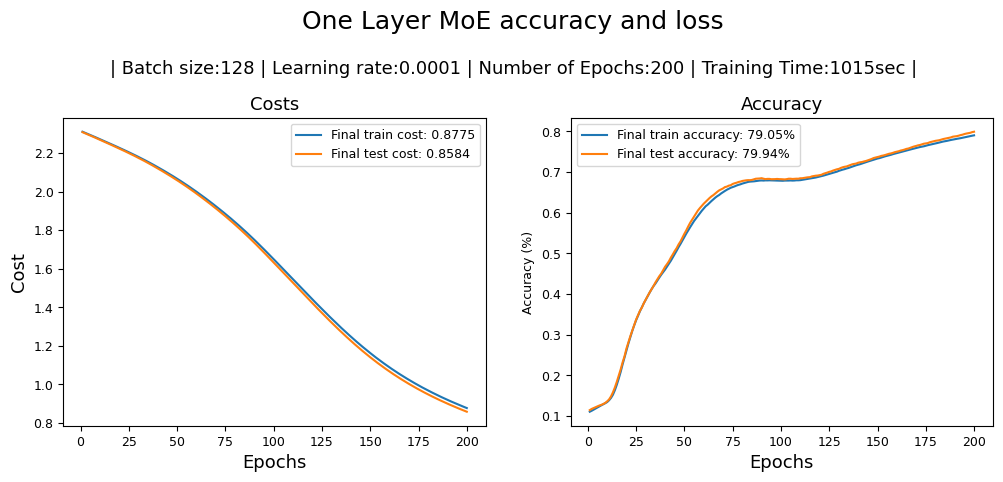

In [20]:
training_curve_plot(
    title="One Layer MoE accuracy and loss", 
    train_costs=training_loss, 
    test_costs=test_loss, 
    train_accuracy=training_accuracy, 
    test_accuracy=test_accuracy, 
    batch_size=BATCH_SIZE, 
    learning_rate=LEARNING_RATE, 
    training_time=training_duration, 
    epochs=EPOCHS)

## 4. Evaluation phase

### 4.1 Set-up

In [21]:
moe.eval()

# Access model parameters and nodes
for name, param in moe.named_parameters():
    print(name, param.shape)
print(get_graph_node_names(moe))

gate.l_1.weight torch.Size([10, 784])
gate.l_1.bias torch.Size([10])
gate.output.weight torch.Size([2, 10])
gate.output.bias torch.Size([2])
experts.0.l_1.weight torch.Size([25, 784])
experts.0.l_1.bias torch.Size([25])
experts.0.output.weight torch.Size([10, 25])
experts.0.output.bias torch.Size([10])
experts.1.l_1.weight torch.Size([25, 784])
experts.1.l_1.bias torch.Size([25])
experts.1.output.weight torch.Size([10, 25])
experts.1.output.bias torch.Size([10])
(['x', 'gate.l', 'gate.relu', 'gate.output', 'gate.softmax', 'experts.0.l', 'experts.0.relu', 'experts.0.output', 'experts.1.l', 'experts.1.relu', 'experts.1.output', 'stack', 'unsqueeze', 'bmm', 'squeeze'], ['x', 'gate.l', 'gate.relu', 'gate.output', 'gate.softmax', 'experts.0.l', 'experts.0.relu', 'experts.0.output', 'experts.1.l', 'experts.1.relu', 'experts.1.output', 'stack', 'unsqueeze', 'bmm', 'squeeze'])


In [22]:
# For getting the probability distribution for experts
return_nodes = {
    "gate.softmax" : "probs"
}

# Geeting the gating network
moe_gating = create_feature_extractor(moe, return_nodes=return_nodes)
moe_gating.eval()

SoftMOE(
  (gate): Module(
    (l_1): Linear(in_features=784, out_features=10, bias=True)
    (relu_1): ReLU()
    (output): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [ ]:
# 1. Group test dataset indices by their label (0-9)
seperated_data_indices = [[] for _ in range(10)]
for idx, (data, label) in enumerate(test_dataset):
    seperated_data_indices[label].append(idx)
    
print(f"Grouping example: Found {len(seperated_data_indices[7])} samples for label 7.")

# 2. Create Subsets and DataLoaders
test_subsets = []
test_loaders = []

for label in range(10):
    indices = seperated_data_indices[label]
    
    # Create a Subset of the original dataset using the collected indices
    subset = Subset(test_dataset, indices)
    test_subsets.append(subset)
    
    # Create a DataLoader for the subset. Using len(indices) as batch_size 
    loader = DataLoader(
        dataset=subset, 
        batch_size=len(indices), 
        shuffle=False
    )
    test_loaders.append(loader)

Grouping indices for 10000 samples...
Grouping complete.
Example: Found 1028 samples for label 7.

Subsets and DataLoaders created.
Total DataLoaders created: 10 (one for each label).


### 4.2 Evaluation

In [32]:
test_loss = [[] for _ in range(10)]
test_accuracy = [[] for _ in range(10)]
expert_probs = [[] for _ in range(10)]

for idx, loader in enumerate(test_loaders):
    with torch.no_grad():
        for batch_index, (data, label) in enumerate(loader):
            
            # Gating layer forward pass
            test_probs = moe_gating(data)
            
            # Full model forward pass
            test_predictions = moe(data)
            
            # average along the columns of all predictions to get an idex of which expert is used
            test_probs = torch.mean(test_probs["probs"], dim = 0).tolist()
            expert_probs[idx].append(test_probs)
            
            # test loss and move to cpu so I can plot
            batch_loss = loss(test_predictions, label).to(DEVICE)
            
            # append statistics
            test_loss[idx].append(batch_loss)
            test_accuracy[idx].append(calculate_accuracy(test_predictions.data, label))

In [33]:
# Initialize lists to store a single value (the statistic) for each digit (0-9)
final_test_loss = [None] * 10
final_test_accuracy = [None] * 10
expert_probs_per_digit = [None] * 10

# Iterate through the 10 data loaders (one for each digit)
for idx, loader in enumerate(test_loaders):
    with torch.no_grad():
        # Since each loader contains ALL samples for one digit, we expect only ONE batch.
        for data, label in loader:
            data = data.to(DEVICE)
            label = label.to(DEVICE)
            
            # Gating layer forward pass (assumes moe_gating returns a dict with "probs")
            test_probs_output = moe_gating(data) 
            
            # Full model forward pass
            test_predictions = moe(data)
            
            # Calculate Mean Expert Probabilities for this digit
            # The result is the average probability for each expert across all samples
            mean_expert_probs = torch.mean(test_probs_output["probs"], dim=0).tolist()
            expert_probs_per_digit[idx] = mean_expert_probs
            
            batch_loss = loss(test_predictions, label)
            batch_accuracy = calculate_accuracy(test_predictions.data, label)
            
            final_test_loss[idx] = batch_loss.item()
            final_test_accuracy[idx] = batch_accuracy
            
            break # Only one batch is expected

### 4.3 Plots

In [34]:
def expert_activation_plot(expert_probabilties: list[float], expert_num: int):
    plt.figure(figsize=(10, 2))
    plt.imshow(expert_probabilties, cmap='viridis', aspect='auto')
    plt.colorbar(label='Value')

    plt.title("Probabaility of each expert activating for digits in MNIST")
    plt.xlabel("Number")
    plt.ylabel("Expert")
    
    # Add x axis ticks for class labels
    plt.xticks(ticks=np.arange(10), labels=[str(i) for i in range(0, 10)])

    # Add y axis ticks for expert labels
    yticks = [i for i in range(expert_num)]
    yticks_labels = [f"Expert {i}" for i in range(expert_num)]
    plt.yticks(yticks, yticks_labels)
    
    plt.show()

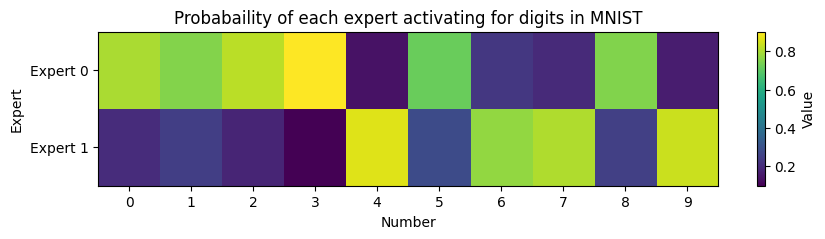

In [35]:
expert_probs_per_digit = np.array(expert_probs_per_digit).squeeze().T
expert_activation_plot(expert_probs_per_digit, expert_num=EXPERT_NUM)